In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#######
IN_DATA_FNAMES = ['/oak/stanford/orgs/kipac/users/delon/LensQuEst/map_sims_800x800_20x20_%d.pkl'%(i) for i in range(1,11)]
import warnings
warnings.filterwarnings("ignore")
#####

In [3]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

In [4]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib
from tqdm import trange, tqdm

In [5]:
print("Map properties")

# number of pixels for the flat map
nX = 800
nY =800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [6]:
# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S4/SO specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.ftotal(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

In [7]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [8]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


In [9]:
in_data = {}

for fname in tqdm(IN_DATA_FNAMES):
    f = open(fname, 'rb') 
    c_in_data = pickle.load(f) 
    f.close()
    for key in c_in_data:
        if(key not in in_data.keys()):
            in_data[key] = np.array(c_in_data[key])
        else:
            in_data[key] = np.vstack( (in_data[key],np.array(c_in_data[key])) )


for key in in_data:
    print(key, np.shape(in_data[key]))


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]

cmb0F_1 (100, 800, 401)
kCmbF_1 (100, 800, 401)
lCmbF_1 (100, 800, 401)
lCmbF_o1_1 (100, 800, 401)
lCmbF_o2_1 (100, 800, 401)
lCmbF_o3_1 (100, 800, 401)
lCmbF_o4_1 (100, 800, 401)
fgF_1 (100, 800, 401)
noiseF_1 (100, 800, 401)
totalF_1 (100, 800, 401)
totalF_0 (100, 800, 401)


In [10]:
pairs = [
   [0,0], #N0
   [0,1], #kappa
   [1,0], #kappa
   [0,2], #N1
   [1,1], #N1
   [2,0], #N1
    [0,3], #should vanish
    [1,2], #should vanish
    [2,1], #should vanish
    [3,0], #should vanish
    [0,4], #N2 
    [1,3], #N2
    [2,2], #N2
    [3,1], #N2
    [4,0], #N2
   [-1, -1], #QE
   [-2, -2], #unlensed
]


data_names = {
    0: 'cmb0F_1',
    1: 'lCmbF_o1_1',
    2: 'lCmbF_o2_1',
    3: 'lCmbF_o3_1',
    4: 'lCmbF_o4_1',
    -1: 'lCmbF_1',
    -2: 'totalF_0',
}

In [11]:
data = {}
pbar = trange(len(pairs))
for pair_idx in pbar:
    pair = pairs[pair_idx]
    pbar.set_description("Processing pair %d %d" %(pair[0], pair[1]))
    f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/QE_and_Nhat_from_map_sims_800x800_20x20_Clunlensed_weight_%d_%d.pkl'%(pair[0], pair[1]), 'rb') 
    c_data = pickle.load(f)
    f.close()
    data = data | c_data

Processing pair -2 -2: 100%|██████████| 17/17 [00:27<00:00,  1.64s/it]


In [12]:
for key in data:
    print(key, np.shape(data[key]))

00 (100, 800, 401)
00_sqrtN (100, 800, 401)
01 (100, 800, 401)
01_sqrtN (0,)
10 (100, 800, 401)
10_sqrtN (0,)
02 (100, 800, 401)
02_sqrtN (0,)
11 (100, 800, 401)
11_sqrtN (100, 800, 401)
20 (100, 800, 401)
20_sqrtN (0,)
03 (100, 800, 401)
03_sqrtN (0,)
12 (100, 800, 401)
12_sqrtN (0,)
21 (100, 800, 401)
21_sqrtN (0,)
30 (100, 800, 401)
30_sqrtN (0,)
04 (100, 800, 401)
04_sqrtN (0,)
13 (100, 800, 401)
13_sqrtN (0,)
22 (100, 800, 401)
22_sqrtN (100, 800, 401)
31 (100, 800, 401)
31_sqrtN (0,)
40 (100, 800, 401)
40_sqrtN (0,)
-1-1 (100, 800, 401)
-1-1_sqrtN (100, 800, 401)
-2-2 (100, 800, 401)
-2-2_sqrtN (100, 800, 401)


In [13]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
    sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    return lCen, Cls, sCls

def combine_sketchy(Cl0, Cli):
    n_runs = np.shape(Cl0)[0]
    print(n_runs, np.shape(Cl0))
    ret = np.copy(Cl0)
    ret = np.transpose(ret, axes=[1,2,0])
    ret[1] = np.array([
        [Cl0[run_idx][1][bin_idx]+
         sum([Cli[i][run_idx][1][bin_idx] for i in range(len(Cli))]) 
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    ret[2] = np.array([[np.sqrt(Cl0[run_idx][2][bin_idx]**2+sum([Cli[i][run_idx][2][bin_idx]**2 
                                                               for i in range(len(Cli))]))
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    return np.transpose(ret, axes=[2,0,1])

In [14]:
ps_data = {}

In [52]:
#estimate RDN0
ck = 'RDN(0)'

def tmp_combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)
#     sCls =  np.sum(np.transpose(Cls_tot, axes=[1,2,0])[2], axis=1)
    sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))
    return lCen, Cls, sCls


for d_idx in trange(len(in_data['totalF_1'])):
    RDN0_fname = '/oak/stanford/orgs/kipac/users/delon/LensQuEst/RDN0-in_data-%d.pkl'%(d_idx)
    f = open(RDN0_fname, 'rb') 
    RDN0_data = pickle.load(f)
    f.close()
    ds1s = RDN0_data['ds1s']
    s1ds = RDN0_data['s1ds']
    s1s2s= RDN0_data['s1s2s']
    s2s1s= RDN0_data['s2s1s']

    c_data = None
    for i in range(len(ds1s)):
        ds1 = ds1s[i]
        s1d = s1ds[i]
        s1s2= s1s2s[i]
        s2s1= s2s1s[i]
        c_data = []

        for s,a,b in [[1,ds1,ds1], [1,ds1,s1d], [1,s1d,ds1],[1,s1d,s1d],[-1,s1s2,s1s2],[-1,s1s2,s2s1]]:
            t0, t1, t2 = baseMap.crossPowerSpectrum(dataFourier1=a, 
                                                    dataFourier2=b)
            c_data += s*[[t0,t1,t2]] 

        c_ps_data = {}

        c_ps_data[ck] = [0,0,0]

        c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = tmp_combine_Cl(c_data)

        if(c_data is None):
            c_data = np.array([c_ps_data[ck]])
        else:
            c_data = np.vstack((c_data, np.array([c_ps_data[ck]])))
    RDN0_for_data = combine_Cl(c_data)
    del c_data
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

  1%|          | 1/100 [00:07<12:33,  7.61s/it]

5 (5, 3, 50)


  2%|▏         | 2/100 [00:15<12:36,  7.72s/it]

5 (5, 3, 50)


  3%|▎         | 3/100 [00:23<12:38,  7.82s/it]

5 (5, 3, 50)


  4%|▍         | 4/100 [00:31<12:34,  7.86s/it]

5 (5, 3, 50)


  5%|▌         | 5/100 [00:39<12:29,  7.89s/it]

5 (5, 3, 50)


  6%|▌         | 6/100 [00:46<12:13,  7.81s/it]

5 (5, 3, 50)


  7%|▋         | 7/100 [00:54<12:08,  7.83s/it]

5 (5, 3, 50)


  8%|▊         | 8/100 [01:02<11:52,  7.74s/it]

5 (5, 3, 50)


  9%|▉         | 9/100 [01:09<11:40,  7.70s/it]

5 (5, 3, 50)


 10%|█         | 10/100 [01:17<11:35,  7.73s/it]

5 (5, 3, 50)


 11%|█         | 11/100 [01:25<11:26,  7.71s/it]

5 (5, 3, 50)


 12%|█▏        | 12/100 [01:32<11:15,  7.68s/it]

5 (5, 3, 50)


 13%|█▎        | 13/100 [01:40<11:06,  7.66s/it]

5 (5, 3, 50)


 14%|█▍        | 14/100 [01:48<10:57,  7.64s/it]

5 (5, 3, 50)


 15%|█▌        | 15/100 [01:57<11:26,  8.08s/it]

5 (5, 3, 50)


 16%|█▌        | 16/100 [02:04<11:09,  7.97s/it]

5 (5, 3, 50)


 17%|█▋        | 17/100 [02:12<10:50,  7.84s/it]

5 (5, 3, 50)


 18%|█▊        | 18/100 [02:20<10:35,  7.75s/it]

5 (5, 3, 50)


 19%|█▉        | 19/100 [02:27<10:20,  7.66s/it]

5 (5, 3, 50)


 20%|██        | 20/100 [02:35<10:19,  7.75s/it]

5 (5, 3, 50)


 21%|██        | 21/100 [02:43<10:08,  7.71s/it]

5 (5, 3, 50)


 22%|██▏       | 22/100 [02:50<09:55,  7.64s/it]

5 (5, 3, 50)


 23%|██▎       | 23/100 [02:58<09:49,  7.66s/it]

5 (5, 3, 50)


 24%|██▍       | 24/100 [03:05<09:41,  7.65s/it]

5 (5, 3, 50)


 25%|██▌       | 25/100 [03:13<09:29,  7.59s/it]

5 (5, 3, 50)


 26%|██▌       | 26/100 [03:21<09:23,  7.62s/it]

5 (5, 3, 50)


 27%|██▋       | 27/100 [03:29<09:27,  7.77s/it]

5 (5, 3, 50)


 28%|██▊       | 28/100 [03:36<09:21,  7.80s/it]

5 (5, 3, 50)


 29%|██▉       | 29/100 [03:44<09:12,  7.78s/it]

5 (5, 3, 50)


 30%|███       | 30/100 [03:52<09:01,  7.73s/it]

5 (5, 3, 50)


 31%|███       | 31/100 [04:00<09:11,  7.99s/it]

5 (5, 3, 50)


 32%|███▏      | 32/100 [04:08<08:55,  7.88s/it]

5 (5, 3, 50)


 33%|███▎      | 33/100 [04:17<09:06,  8.16s/it]

5 (5, 3, 50)


 34%|███▍      | 34/100 [04:25<08:50,  8.04s/it]

5 (5, 3, 50)


 35%|███▌      | 35/100 [04:32<08:37,  7.96s/it]

5 (5, 3, 50)


 36%|███▌      | 36/100 [04:40<08:30,  7.97s/it]

5 (5, 3, 50)


 37%|███▋      | 37/100 [04:49<08:24,  8.01s/it]

5 (5, 3, 50)


 38%|███▊      | 38/100 [04:57<08:24,  8.14s/it]

5 (5, 3, 50)


 39%|███▉      | 39/100 [05:05<08:16,  8.14s/it]

5 (5, 3, 50)


 40%|████      | 40/100 [05:13<08:06,  8.11s/it]

5 (5, 3, 50)


 41%|████      | 41/100 [05:21<07:51,  8.00s/it]

5 (5, 3, 50)


 42%|████▏     | 42/100 [05:29<07:39,  7.93s/it]

5 (5, 3, 50)


 43%|████▎     | 43/100 [05:36<07:28,  7.86s/it]

5 (5, 3, 50)


 44%|████▍     | 44/100 [05:44<07:16,  7.79s/it]

5 (5, 3, 50)


 45%|████▌     | 45/100 [05:52<07:05,  7.74s/it]

5 (5, 3, 50)


 46%|████▌     | 46/100 [05:59<06:56,  7.72s/it]

5 (5, 3, 50)


 47%|████▋     | 47/100 [06:07<06:48,  7.70s/it]

5 (5, 3, 50)


 48%|████▊     | 48/100 [06:15<06:40,  7.70s/it]

5 (5, 3, 50)


 49%|████▉     | 49/100 [06:22<06:30,  7.66s/it]

5 (5, 3, 50)


 50%|█████     | 50/100 [06:30<06:23,  7.68s/it]

5 (5, 3, 50)


 51%|█████     | 51/100 [06:38<06:14,  7.65s/it]

5 (5, 3, 50)


 52%|█████▏    | 52/100 [06:45<06:05,  7.61s/it]

5 (5, 3, 50)


 53%|█████▎    | 53/100 [06:53<05:56,  7.59s/it]

5 (5, 3, 50)


 54%|█████▍    | 54/100 [07:00<05:49,  7.60s/it]

5 (5, 3, 50)


 55%|█████▌    | 55/100 [07:08<05:41,  7.60s/it]

5 (5, 3, 50)


 56%|█████▌    | 56/100 [07:15<05:33,  7.58s/it]

5 (5, 3, 50)


 57%|█████▋    | 57/100 [07:23<05:26,  7.58s/it]

5 (5, 3, 50)


 58%|█████▊    | 58/100 [07:30<05:17,  7.56s/it]

5 (5, 3, 50)


 59%|█████▉    | 59/100 [07:38<05:09,  7.56s/it]

5 (5, 3, 50)


 60%|██████    | 60/100 [07:45<05:00,  7.52s/it]

5 (5, 3, 50)


 61%|██████    | 61/100 [07:53<04:55,  7.58s/it]

5 (5, 3, 50)


 62%|██████▏   | 62/100 [08:01<04:48,  7.58s/it]

5 (5, 3, 50)


 63%|██████▎   | 63/100 [08:08<04:40,  7.59s/it]

5 (5, 3, 50)


 64%|██████▍   | 64/100 [08:16<04:32,  7.56s/it]

5 (5, 3, 50)


 65%|██████▌   | 65/100 [08:23<04:24,  7.57s/it]

5 (5, 3, 50)


 66%|██████▌   | 66/100 [08:31<04:17,  7.59s/it]

5 (5, 3, 50)


 67%|██████▋   | 67/100 [08:39<04:10,  7.60s/it]

5 (5, 3, 50)


 68%|██████▊   | 68/100 [08:46<04:03,  7.60s/it]

5 (5, 3, 50)


 69%|██████▉   | 69/100 [08:54<03:56,  7.63s/it]

5 (5, 3, 50)


 70%|███████   | 70/100 [09:02<03:49,  7.65s/it]

5 (5, 3, 50)


 71%|███████   | 71/100 [09:09<03:42,  7.67s/it]

5 (5, 3, 50)


 72%|███████▏  | 72/100 [09:17<03:35,  7.69s/it]

5 (5, 3, 50)


 73%|███████▎  | 73/100 [09:25<03:28,  7.71s/it]

5 (5, 3, 50)


 74%|███████▍  | 74/100 [09:33<03:19,  7.69s/it]

5 (5, 3, 50)


 75%|███████▌  | 75/100 [09:40<03:12,  7.69s/it]

5 (5, 3, 50)


 76%|███████▌  | 76/100 [09:48<03:03,  7.64s/it]

5 (5, 3, 50)


 77%|███████▋  | 77/100 [09:55<02:56,  7.66s/it]

5 (5, 3, 50)


 78%|███████▊  | 78/100 [10:03<02:48,  7.64s/it]

5 (5, 3, 50)


 79%|███████▉  | 79/100 [10:11<02:41,  7.68s/it]

5 (5, 3, 50)


 80%|████████  | 80/100 [10:19<02:34,  7.71s/it]

5 (5, 3, 50)


 81%|████████  | 81/100 [10:26<02:26,  7.71s/it]

5 (5, 3, 50)


 82%|████████▏ | 82/100 [10:34<02:17,  7.66s/it]

5 (5, 3, 50)


 83%|████████▎ | 83/100 [10:42<02:10,  7.66s/it]

5 (5, 3, 50)


 84%|████████▍ | 84/100 [10:49<02:02,  7.65s/it]

5 (5, 3, 50)


 85%|████████▌ | 85/100 [10:57<01:53,  7.59s/it]

5 (5, 3, 50)


 86%|████████▌ | 86/100 [11:04<01:45,  7.54s/it]

5 (5, 3, 50)


 87%|████████▋ | 87/100 [11:12<01:38,  7.55s/it]

5 (5, 3, 50)


 88%|████████▊ | 88/100 [11:19<01:31,  7.63s/it]

5 (5, 3, 50)


 89%|████████▉ | 89/100 [11:27<01:23,  7.60s/it]

5 (5, 3, 50)


 90%|█████████ | 90/100 [11:35<01:16,  7.62s/it]

5 (5, 3, 50)


 91%|█████████ | 91/100 [11:42<01:08,  7.66s/it]

5 (5, 3, 50)


 92%|█████████▏| 92/100 [11:50<01:01,  7.71s/it]

5 (5, 3, 50)


 93%|█████████▎| 93/100 [11:58<00:53,  7.63s/it]

5 (5, 3, 50)


 94%|█████████▍| 94/100 [12:05<00:45,  7.63s/it]

5 (5, 3, 50)


 95%|█████████▌| 95/100 [12:13<00:38,  7.65s/it]

5 (5, 3, 50)


 96%|█████████▌| 96/100 [12:21<00:30,  7.67s/it]

5 (5, 3, 50)


 97%|█████████▋| 97/100 [12:28<00:23,  7.69s/it]

5 (5, 3, 50)


 98%|█████████▊| 98/100 [12:36<00:15,  7.69s/it]

5 (5, 3, 50)


 99%|█████████▉| 99/100 [12:44<00:07,  7.68s/it]

5 (5, 3, 50)


100%|██████████| 100/100 [12:51<00:00,  7.72s/it]

5 (5, 3, 50)


In [55]:
print(np.shape(ps_data['RDN(0)']))

(100, 3, 50)


In [16]:
#estimate N0
ck = 'N0'

for data_idx in range(len(data['00'])):
    q00 = data['00'][data_idx]
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=q00)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

In [17]:
#estimate kk
ck = 'kk'


for data_idx in range(min(len(data['01']), len(data['10']))):
    q01 = data['01'][data_idx]
    q10 = data['10'][data_idx]
    kCmbFourier = in_data['kCmbF_1'][data_idx]
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.crossPowerSpectrum(dataFourier1=q10+q01, dataFourier2=kCmbFourier)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

In [18]:
#estimate <QE QE>
ck = 'QEQE'
for data_idx in range(len(data['-1-1'])):
    QE = data['-1-1'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=QE)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

In [19]:
#estimate Nhat
ck = 'Nhat'
for data_idx in range(len(data['-1-1_sqrtN'])):
    sqrtNhat = data['-1-1_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck],np.array([c_ps_data[ck]])))  

In [20]:
#estimate GRF Nhat
ck = 'GRF'
for data_idx in range(len(data['-2-2_sqrtN'])):
    sqrtNhat = data['-2-2_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack(( ps_data[ck], np.array([c_ps_data[ck]])))  

In [21]:
#estimate <kT kT>
ck = 'kT'

for data_idx in range(len(in_data['kCmbF_1'])):
    kT = in_data['kCmbF_1'][data_idx]
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=kT)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((ps_data[ck], np.array([c_ps_data[ck]])))  

In [102]:
labels={
    'N0':r'$N^{(0)}$',
    'GRF':r'$\hat N$ on GRF',
    'kT': r'$\left<\kappa\kappa\right>$',
    'kk':r'$\left<(\mathcal Q(T^0, T^1)+\mathcal Q(T^1, T^0))\kappa\right>$',
    'N1':r'$N^{(1)}$',
    'N2':r'$N^{(2)}$',
    'N2+':r'$N^{(2)}+\dots$',
    'N3+':r'$N^{(3)}+\dots$',
    'RDN(0)':r'${\rm RDN}^{(0)}$',
    'RDN(0)o2':r'${\rm RDN}^{(0)}$',
    'QEQE':r'$\left<\hat\kappa\hat\kappa\right>$',
    'QEQE-Nhat':r'$\left<\hat\kappa\hat\kappa\right>-\hat N$',
    'QEQE-RDN(0)':r'$\left<\hat\kappa\hat\kappa\right>-{\rm RDN}^{(0)}$',
    'Nhat':r'$\hat N$',
    'N1+':r'$N^{(1)}+\dots$',
    'KK+N1+': r'$\left<(\mathcal Q(T^0, T^1)+\mathcal Q(T^1, T^0))\kappa\right>+N^{(1)}+\dots$',
    'QEQE-2Nhat+Ntheory':r'$\left<\hat\kappa\hat\kappa\right>-2\hat N+N_{\rm theory}$',
    'QEQE-Ntheory':r'$\left<\hat\kappa\hat\kappa\right>-N_{\rm theory}$',
    'QEQE-Ntheory-N1':r'$\left<\hat\kappa\hat\kappa\right>-N_{\rm theory}-N^{(1)}$',
    'QEQE-N0':r'$\left<\hat\kappa\hat\kappa\right>- N^{(0)}$',
    'QEQE-kTkT-Nhat': r'$\left<\hat\kappa\hat\kappa\right>-\left<\kappa\kappa\right>-\hat N$',
    'QEQE-kTkT-Ntheory':r'$\left<\hat\kappa\hat\kappa\right>-\left<\kappa\kappa\right>-N_{\rm theory}$',
    'QEQE-kTkT-RDN(0)':r'$\left<\hat\kappa\hat\kappa\right>-\left<\kappa\kappa\right>-{\rm RDN}^{(0)}$',

}


In [95]:
def graph_from_keys(c_keys, offset=0.03, factor=lambda x:1):
    
    
    offsets = dict(zip(c_keys,[i*offset for i in range(len(c_keys))]))
    colors = dict(zip(c_keys,[plt.colormaps["gist_rainbow"]((i+1)/len(c_keys)) for i in range(len(c_keys))] ))
    if(len(c_keys)<=3):
        colors = dict(zip(c_keys, ['red', 'green', 'blue']))
    fig,ax = plt.subplots(nrows=1, figsize=(10,8))

    ell = baseMap.l.flatten()
    theory=[p2d_cmblens.fPinterp, Ntheory]
    theory_l=[r'$\big<\kappa\kappa\big>$', r'$N^{(0)}_{\rm theory}$']
    theory_s=['black', 'lightgrey']
    for f,l,sty in zip(theory, theory_l, theory_s):
        L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
        ClExpected = np.array(list(map(f, L)))
        ax.plot(L, factor(L)*ClExpected, sty, label=l)

    for key in c_keys:
        lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    
        Cl = factor(lCen)*Cl
        sCl = factor(lCen)*sCl
        
        offset = offsets[key]
        tmp = [l*np.exp(offset)-l for l in lCen]
        lCen += tmp

        Ipos = np.where(Cl>=1e-30)
        Ineg = np.where(Cl<=-1e-30)

        ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                    fmt='-', capsize=3, capthick=1, label=labels[key], c=colors[key])
        tmp_data = {
            'x': lCen[Ipos],
            'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
            'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
        ax.fill_between(**tmp_data,  alpha=.25, color=colors[key])

        
        ax.errorbar(lCen[Ineg], -(Cl[Ineg]), yerr=sCl[Ineg], alpha=.75, 
                    fmt='--', capsize=3, capthick=1, c=colors[key])
        tmp_data = {
            'x': lCen[Ineg],
            'y1': [y - e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])],
            'y2': [y + e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])]}
        ax.fill_between(**tmp_data,  alpha=.25, color=colors[key])

#         print(lCen[Ineg])
#         print('###########')
#         print(lCen[Ipos])

    ax.legend(frameon=False)
    ax.set_xscale('log')
    ax.set_xlabel(r'$\ell$')
    ax.set_yscale('log')
    ax.set_xlim(lMin,2*lMax)
    ax.set_ylim(1.1e-10,.9e-3)
    return fig, ax

In [24]:
ps_data['QEQE-Nhat'] = combine_sketchy(ps_data['QEQE'], [-ps_data['Nhat']])

100 (100, 3, 50)


100 (100, 3, 50)


In [25]:
import numpy as np
from multiprocessing import Pool
from tqdm import trange

# Define a function to compute Ntheory_evaled for a given iteration
def compute_Ntheory_evaled(_):
    # Replace your original code here
    t0, t1 = baseMap.binTheoryPowerSpectrum(Ntheory, nBins=51)
    t2 = np.zeros_like(t1)
    return [t0, t1, t2]

# Set the number of iterations for parallel processing
num_iterations = 100

# Create a pool of worker processes using all available CPU cores
pool = Pool()

# Use the map function to parallelize the computation of Ntheory_evaled
Ntheory_evaled = list(tqdm(pool.imap(compute_Ntheory_evaled, range(num_iterations)), total=num_iterations))

# Convert the list of results to a NumPy array
Ntheory_evaled = np.array(Ntheory_evaled)

# Clean up the pool of worker processes
pool.close()
pool.join()

# Continue with your original code
ps_data['QEQE-Ntheory'] = combine_sketchy(ps_data['QEQE'], [-Ntheory_evaled])

100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


100 (100, 3, 50)


In [26]:
Ntheory_evaled.shape

(100, 3, 50)

In [27]:
ps_data['QEQE-N0'] = combine_sketchy(ps_data['QEQE'], [ -ps_data['N0']])
ps_data['QEQE-2Nhat+Ntheory'] = combine_sketchy(ps_data['QEQE'], [-2*ps_data['Nhat'],Ntheory_evaled])

100 (100, 3, 50)
100 (100, 3, 50)


In [91]:
ps_data['RDN(0)o2'] = np.copy(ps_data['RDN(0)'])
print(np.shape(ps_data['RDN(0)o2']))
ps_data['RDN(0)o2'] = np.transpose(ps_data['RDN(0)o2'], axes=[1,2,0])

ps_data['RDN(0)o2'][1] = ps_data['RDN(0)o2'][1]/2
ps_data['RDN(0)o2'][2] = ps_data['RDN(0)o2'][2]/2

ps_data['RDN(0)o2'] = np.transpose(ps_data['RDN(0)o2'], axes=[2,0,1])

print(np.shape(ps_data['RDN(0)o2']))


(100, 3, 50)
(100, 3, 50)


100 (100, 3, 50)
100 (100, 3, 50)


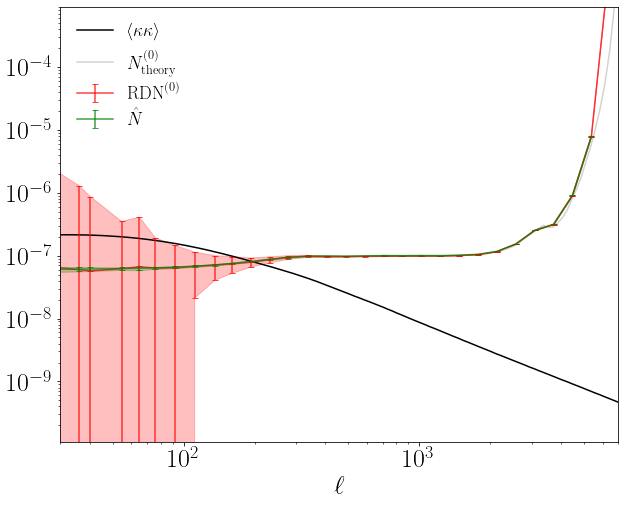

In [96]:

graph_from_keys([  
    'RDN(0)o2',
    'Nhat',
], offset=0.00)
plt.savefig('figures/RDN0.pdf', bbox_inches='tight')



100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)


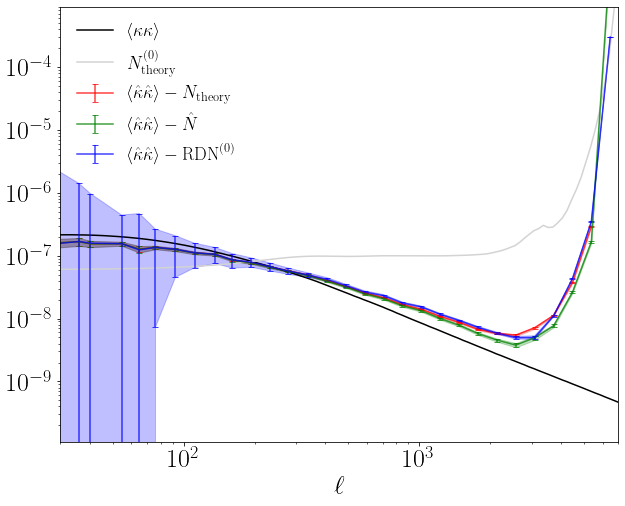

In [97]:
ps_data['QEQE-RDN(0)'] = combine_sketchy(ps_data['QEQE'], [-ps_data['RDN(0)o2']])
graph_from_keys([
#     'QEQE-N0',
    'QEQE-Ntheory',
    'QEQE-Nhat',
    'QEQE-RDN(0)',
#     'RDN(0)o2'
#     'QEQE-2Nhat+Ntheory',
], offset=0.00)
plt.savefig('figures/mNhat_vs_mNtheory_vs_RDN0.pdf', bbox_inches='tight')

100 (100, 3, 50)


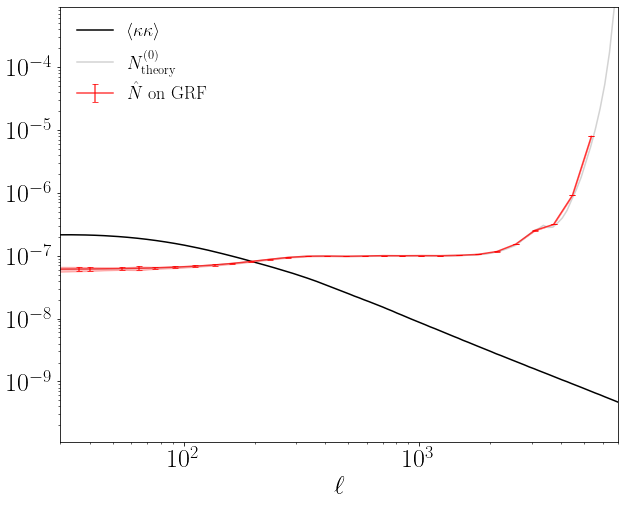

In [98]:
graph_from_keys([
    'GRF',
], offset=0.00)
plt.savefig('figures/Nhat on GRF.pdf', bbox_inches='tight')

In [104]:
#bandaid
ll = ['%d'%l for l in ps_data['QEQE'][0][0]]
#
def corr2(corr_nhat1, 
          corr_nhat2, 
          filename_base, 
          cmap='seismic', 
          cmap2='seismic', 
          label='', 
          label2=''):
    
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['text.usetex'] = True

    plt.rcParams['font.size'] = 20
    plt.rcParams['text.latex.preamble'] = r'\usepackage{xcolor}'
    plt.rcParams['text.latex.preamble'] +='\n'
#     plt.rcParams['text.latex.preamble'] += r'\definecolor{c1}{rgb}{%.1f,%.1f,%.1f}'%(cmap[3][0],cmap[3][1],cmap[3][2])
#     plt.rcParams['text.latex.preamble'] +='\n'
#     plt.rcParams['text.latex.preamble'] +=r'\definecolor{c2}{rgb}{%.1f,%.1f,%.1f}'%(cmap2[3][0],cmap2[3][1],cmap2[3][2])

    
    corr_nhat = np.copy(corr_nhat1)
    sze = len(corr_nhat1)
    mask = np.array([[0 for _ in range(sze)] for _ in range(sze)])
    for i in range(sze-1):
        for j in range(sze-1-i):
            corr_nhat[i][sze-j-1] = corr_nhat2[i][sze-j-1]
            mask[i][sze-j-1] = 1
    plt.figure(figsize=(25,20))
    print(np.shape(corr_nhat))
    print(np.shape(mask))
    
    ax = sns.heatmap(corr_nhat,  cmap=cmap, cbar=True, vmin=-1, vmax=1, square=True,
                    cbar_kws={ 'ticks':[],
                              "orientation": "horizontal", 'pad':-0.17, 'shrink':0.3})
    
    sns.heatmap(corr_nhat, mask=mask, cmap=cmap2, cbar=True, ax=ax, vmin=-1, vmax=1,square=True,label=label,
           cbar_kws={'label': r"$\rho$","orientation": "horizontal", 'pad':0.1,  'shrink':0.3})
    

    ax.tick_params(axis=u'x', which=u'both',labelrotation=90)
    ax.set_xticks(np.arange(len(ll))+0.5, labels=ll)
    plt.xlabel(r'$\ell$'+'\n')

#     ax.legend(frameon=False)

    ax.tick_params(axis=u'y', which=u'both',labelrotation=0)
    ax.set_yticks(np.arange(len(ll))+0.5, labels=ll)
    plt.ylabel(r'$\ell$'+'\n')

    plt.title(r'Correlations for {%s} (Top Left) and {%s} (Bottom Right)'%(label, label2))
    plt.xlim(19, len(ll)-3)
    plt.ylim(19, len(ll)-3)

    plt.savefig('figures/corr_%s.pdf'%(filename_base), bbox_inches='tight')#, use='pgf')


def corr_gen(keys, filename_base):
    Cls_tmp = np.array([None, None])
    for key,idx in zip(keys, range(2)):
        print(np.shape(ps_data[key]))
        Cls_tmp[idx] = np.transpose(np.copy(np.array(ps_data[key])), axes=[1,2,0])[1]

    corrs = np.array([[[(np.corrcoef(Cls_tmp[i][i1], Cls_tmp[i][i2])[1,0])
                          for i1 in range(len(Cls_tmp[i]))]
                         for i2 in range(len(Cls_tmp[i]))]
                         for i in range(2)])

    corr2(corrs[0], corrs[1], 
          label= labels[keys[0]],
         label2=labels[keys[1]], 
         filename_base=filename_base)

(100, 3, 50)
(100, 3, 50)
(50, 50)
(50, 50)


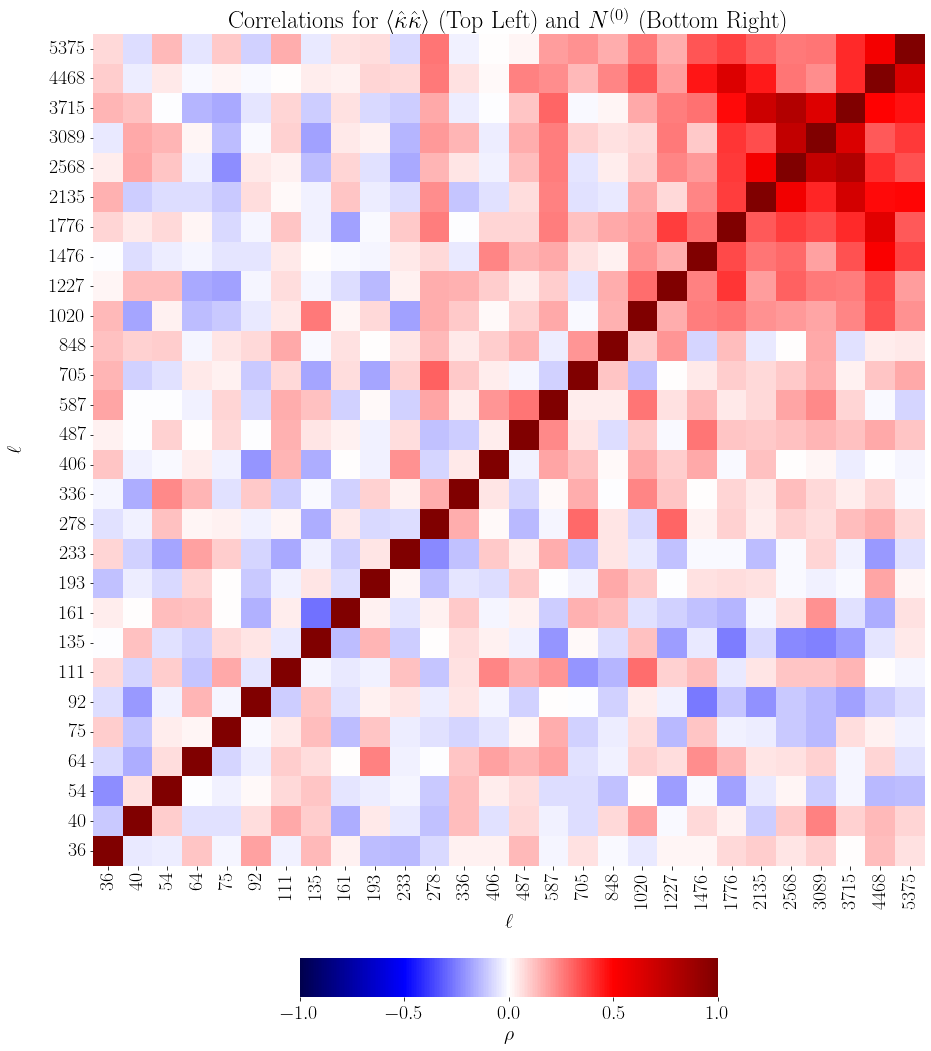

In [105]:
corr_gen(['QEQE', 'N0'], 'QEQEvsN0')

In [106]:
ps_data['QEQE-kTkT-Nhat'] = combine_sketchy(ps_data['QEQE'], [-ps_data['kT'],-ps_data['Nhat']])
ps_data['QEQE-kTkT-Ntheory'] = combine_sketchy(ps_data['QEQE'], [-ps_data['kT'],-Ntheory_evaled])
ps_data['QEQE-kTkT-RDN(0)'] = combine_sketchy(ps_data['QEQE'], [-ps_data['kT'],-ps_data['RDN(0)o2']])

100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)


(100, 3, 50)
(100, 3, 50)
(50, 50)
(50, 50)


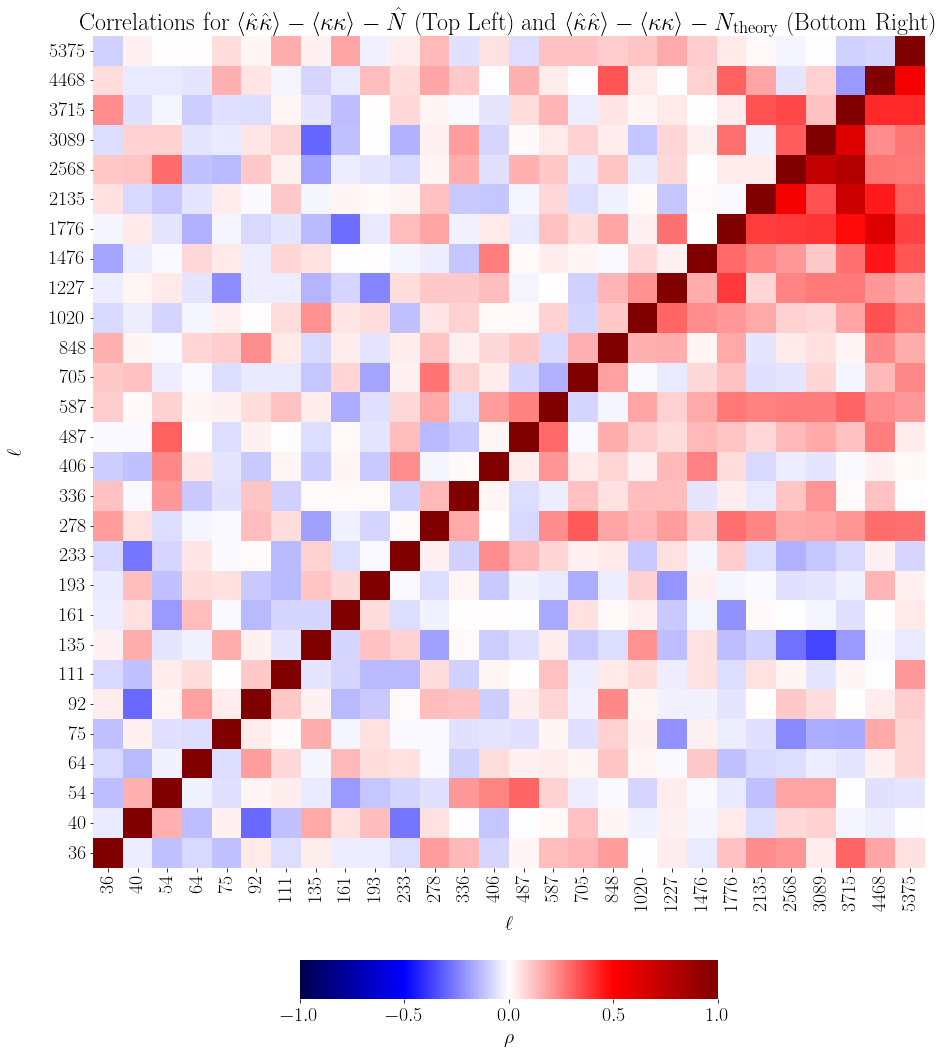

In [107]:
corr_gen(['QEQE-kTkT-Nhat', 'QEQE-kTkT-Ntheory'], 'mNhat_v_mNtheory')

(100, 3, 50)
(100, 3, 50)
(50, 50)
(50, 50)


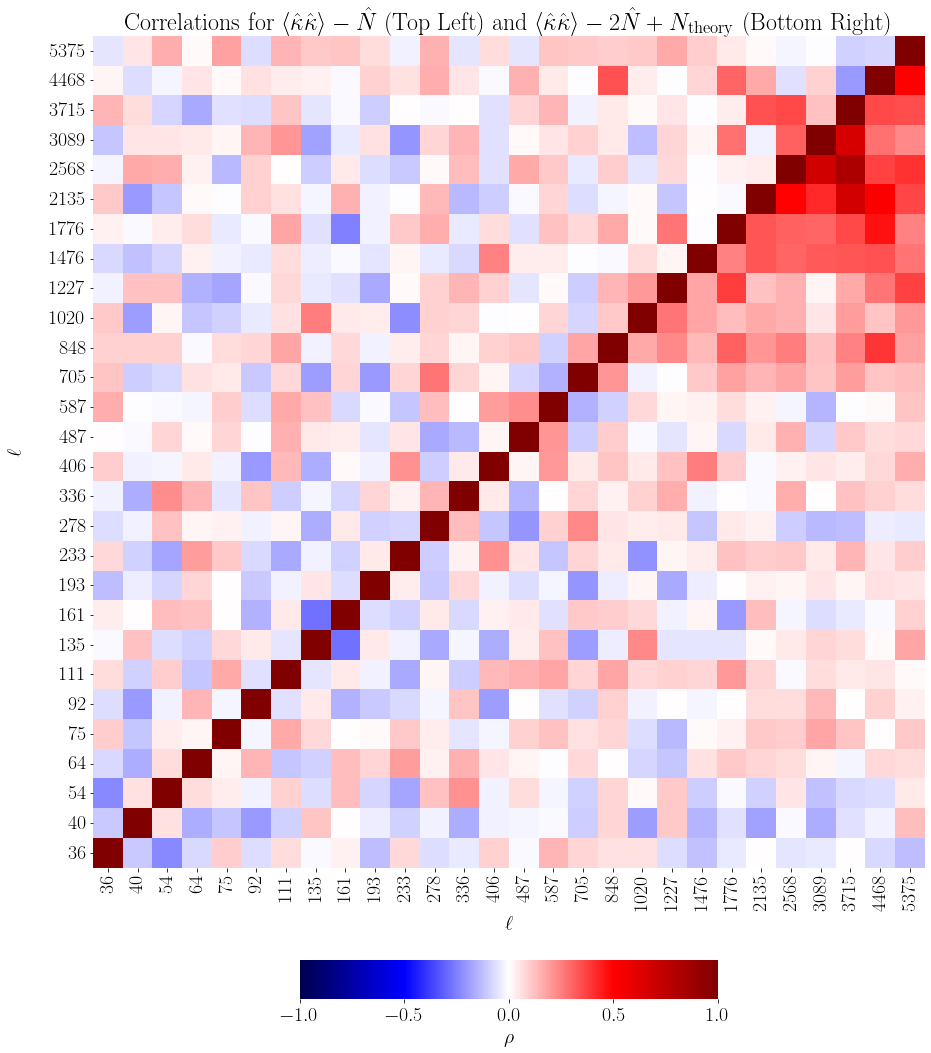

In [108]:
corr_gen(['QEQE-Nhat', 'QEQE-2Nhat+Ntheory'], 'mNhat_v_mNtheory')

(100, 3, 50)
(100, 3, 50)
(50, 50)
(50, 50)


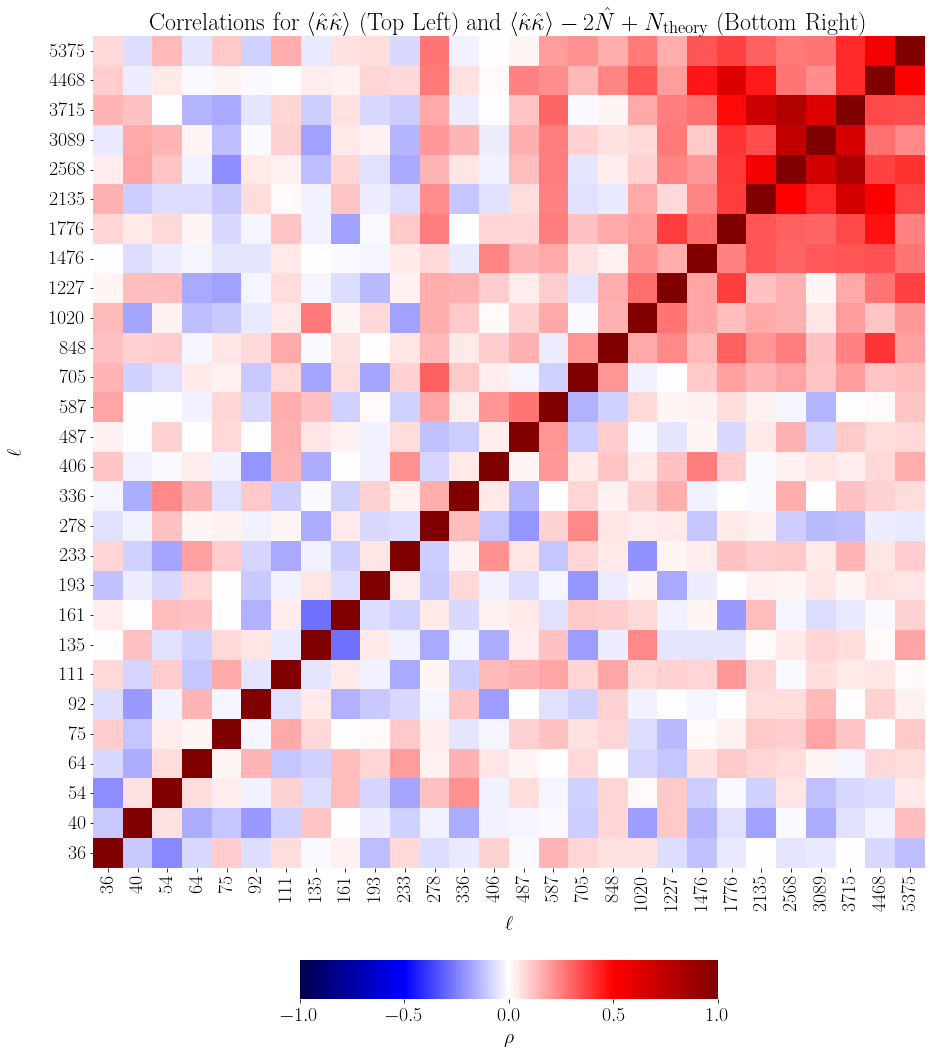

In [109]:
corr_gen(['QEQE', 'QEQE-2Nhat+Ntheory'], 'mNhat_v_mNtheory')

(100, 3, 50)
(100, 3, 50)
(50, 50)
(50, 50)


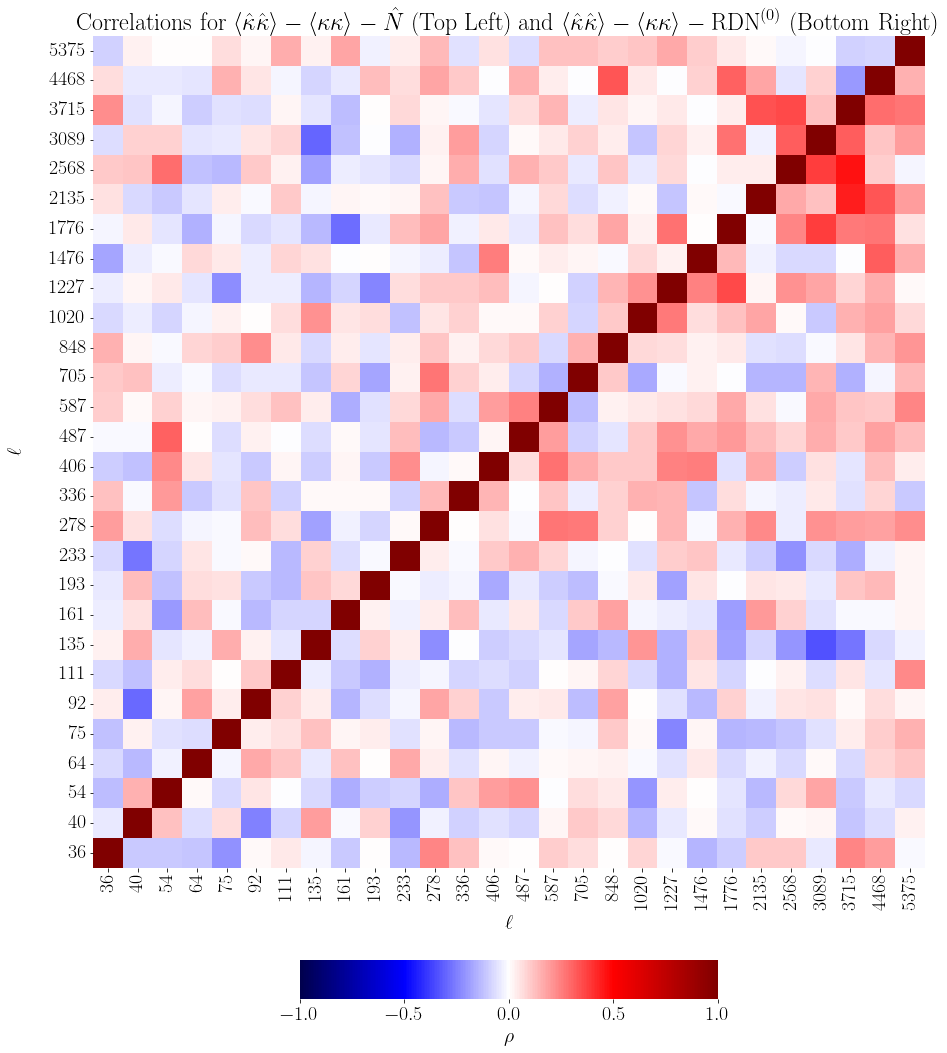

In [110]:
corr_gen(['QEQE-kTkT-Nhat', 'QEQE-kTkT-RDN(0)'], 'mNhat_v_mRDN0')